# Main Analysis Pipeline

# TODO
 * Use Spare DataFrames!!
 * Use sparse matricies in get_measurement
 * swap cdc for CDC

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
sys.path.insert(0, '../modules')
from root_numpy import list_branches
%load_ext memory_profiler
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter
from cylinder import CDC

Populating the interactive namespace from numpy and matplotlib


# Convenience Functions

## Access data

In [2]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]] 

## Import the Signal Hits

In [3]:
def test_labelling(hit_sample, sig_name, momentum_name, value):
    current_labels = hit_sample.get_events()[sig_name]
    momentum_magnitude = np.sqrt(np.square(hit_sample.get_events()[momentum_name+'.fX']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fY']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fZ']))
    pid_values = hit_sample.get_events()[pid_name]
    new_labels = np.logical_and(momentum_magnitude > value, pid_values == 11)
    print "Number of signal now : {}".format(sum(current_labels))
    print "Number of signal actual : {}".format(sum(new_labels))
    print "Number mislabelled : {}".format(hit_sample.n_hits - sum(current_labels == new_labels))

In [4]:
def smear_all_times(hit_sample, smears):
    for branch in hit_sample.data.dtype.names:
        if (branch.endswith("fE") and branch.find("Pos")) \
            or branch.endswith("DetectedTime") \
            or branch.endswith("StartT"):
            print "Smearing Branch " + branch
            hit_sample.data[branch] += smears

In [5]:
def smear_times(cdc_samp, cth_samp, smear):
    assert cdc_samp.n_events == cth_samp.n_events, \
        "ERROR : CDC and CTH have different number of events!\n"+\
        "cdc_samp.n_events {}\n".format(cdc_samp.n_events)+\
        "cth_samp.n_events {}\n".format(cth_samp.n_events)
    random_time_smear = np.random.randint(-smear,smear, size=cdc_samp.n_events)
    cdc_time_smear = random_time_smear[cdc_samp.hits_to_events]
    cth_time_smear = random_time_smear[cth_samp.hits_to_events]
    smear_all_times(cdc_samp, cdc_time_smear)
    smear_all_times(cth_samp, cth_time_smear)

In [6]:
def import_signal(cdc_file, cth_file, emp_branches, import_branches,
                  low_bound, up_bound_cdc, up_bound_cth, smear):
    # Import cdc
    cdc_selection = "CDCHit.fDetectedTime < " + str(up_bound_cdc + smear) + \
                    "&& CDCHit.fDetectedTime > " + str(low_bound - smear)
    cdc_samp = CDCHits(cdc_file, 
                          signal_coding=[1], 
                          hit_type_name=sig_flag,
                          row_name=row_name,
                          branches=import_branches,
                          empty_branches=emp_branches,
                          selection=cdc_selection)

    cdc_samp.data[cdc_samp.hit_type_name] = cdc_samp.data[track_id_name] == 1
    print "Number of CDC Events : " + str(cdc_samp.n_events)
    print "Number of CDC Hits : " + str(cdc_samp.n_hits)

    # Import CTH
    cth_selection = "CTHHit.fStartT < " + str(up_bound_cth + smear) + \
                    "&& CTHHit.fStartT > " + str(low_bound - smear)
    cth_samp = FlatHits(cth_file,
                      tree="CTHHitTree",
                      signal_coding=[1], 
                      hit_type_name=sig_flag,
                      prefix="CTHHit.f",
                      branches=["CTHHit.fStartT",
                                "CTHHit.fTrackID",
                                "CTHHit.fCharge"],
                      selection=cth_selection)
    print "Number of CTH Events : " + str(cth_samp.n_events)
    print "Number of CTH Hits : " + str(cth_samp.n_hits)
    
    passed_events = np.intersect1d(cth_samp.get_signal_hits()[cth_samp.key_name], 
                                   cdc_samp.get_signal_hits()[cdc_samp.key_name])
    cdc_samp.trim_hits(cdc_samp.key_name, values=passed_events)
    cth_samp.trim_hits(cth_samp.key_name, values=passed_events)
    cth_samp.sort_hits("CTHHit.fStartT")
    print "Number of events with both : " + str(len(passed_events))
    return cdc_samp, cth_samp

### Make cuts

In [7]:
def trim_cth_track(cth_samp):    
    # First reduce each CTH hit to the earliest signal hit in that track
    hits_to_keep = []
    for evt in range(cth_samp.n_events):
        sig_hits = cth_samp.get_signal_hits(evt)
        for track in np.unique(sig_hits["CTHHit.fTrackID"]):
            track_hits = cth_samp.filter_hits(sig_hits, "CTHHit.fTrackID", values=track)
            min_time = np.amin(track_hits["CTHHit.fStartT"])
            earliest_hit = track_hits[cth_samp.hits_index_name][track_hits["CTHHit.fStartT"] == min_time][0]
            #if earliest_hit != track_hits[cth_samp.hits_index_name][0]:
            #    print "time error"
            #    break
            #hits_to_keep.append(cth_samp.filter_hits(sig_hits, "CTHHit.fTrackID", values=track)[cth_samp.hits_index_name][0])
            hits_to_keep.append(earliest_hit)
            
    print "Before earliest track cut " + str(cth_samp.n_hits)
    cth_samp.trim_hits(cth_samp.hits_index_name, values=hits_to_keep)
    print "After earliest track cut " + str(cth_samp.n_hits)

In [8]:
def apply_timing_cut(cdc_samp, cth_samp, low_bound, up_bound_cdc, up_bound_cth):
    # Apply the timing filter
    print "Before timing cut"
    before_cdc_nhits = cdc_samp.n_hits
    before_cth_nhits = cth_samp.n_hits
    print "CTH Hits: {}".format(before_cth_nhits)
    print "CDC Hits: {}".format(before_cdc_nhits)
    cdc_samp.trim_hits(variable=cdc_samp.time_name, greater_than=low_bound, less_than=up_bound_cdc)
    cth_samp.trim_hits(variable="CTHHit.fStartT", greater_than=low_bound, less_than=up_bound_cth)
    print "After timing cut"
    print "CTH Hits: {0}, {1:.4f}".format(cth_samp.n_hits, float(cth_samp.n_hits)/before_cth_nhits)
    print "CDC Hits: {0}, {1:.4f}".format(cdc_samp.n_hits, float(cdc_samp.n_hits)/before_cdc_nhits)
    passed_events = np.intersect1d(cth_samp.get_events()[cth_samp.key_name], 
                               cdc_samp.get_events()[cdc_samp.key_name])
    cdc_samp.trim_hits(cdc_samp.key_name, values=passed_events)
    cth_samp.trim_hits(cth_samp.key_name, values=passed_events)
    print "Events left : " + str(len(passed_events))

In [9]:
def filter_cth_time_window(cth_samp):
    # Filter for CTH in time window.  Get the time
    trig_evts = []
    for evt in range(cth_samp.n_events):
        sig_hits = cth_samp.get_signal_hits(evt)
        if len(sig_hits) != 0:
            event_key = cth_samp.get_events(evt)[cth_samp.key_name]
            if len(np.unique(event_key)) != 1:
                print "key error"
                print event_key
                break
            else:
                trig_evts.append(event_key[0])
    trig_evts = np.array(trig_evts)
    print "Events that pass CTH Trigger: {}".format(len(trig_evts))
    return trig_evts

In [10]:
def max_layer_cut(cdc_samp):
    # Filter for max layer is five
    max_layer = []
    gd_max_lay = []
    for evt in range(cdc_samp.n_events):
        these_layers = cdc_samp.geom.point_layers[cdc_samp.get_sig_wires(evt)]
        this_key = cdc_samp.get_events(evt)[cdc_samp.key_name]
        if len(cdc_samp.get_sig_wires(evt)) != 0:
            if np.amax(these_layers) >= 4:
                if len(np.unique(this_key)) != 1:
                    print "key error"
                    print this_key
                    break
                else:
                    gd_max_lay.append(np.unique(this_key)[0])
    gd_max_lay = np.array(gd_max_lay)
    print "Passed Max Layer {}".format(len(gd_max_lay))
    return gd_max_lay

In [11]:
def min_hits_cut(cdc_samp):
    # Filter for number of signal hits
    n_signal_hits  = np.array([len(cdc_samp.get_signal_hits(evt)) 
                             for evt in range(cdc_samp.n_events)])
    n_signal_hits = np.array(n_signal_hits)
    good_n_hits = np.arange(cdc_samp.n_events)[n_signal_hits >= 30]
    good_n_hits = np.unique(cdc_samp.get_events(good_n_hits)[cdc_samp.key_name])
    print "Passed Good Number of Hits : {}".format(len(good_n_hits))
    return good_n_hits

In [12]:
def combine_all_cuts(orig_evts, trig_evts, lay_evts, nhits_evts):
    pass_events = np.intersect1d(orig_evts, trig_evts)
    print "Removed due to CTH Trigger {}".format(len(orig_evts) - len(trig_evts))
    pass_events = np.intersect1d(pass_events, lay_evts)
    print "Removed due to Layer Cut {}".format(len(orig_evts)  - len(lay_evts))
    pass_events = np.intersect1d(pass_events, nhits_evts)
    print "Removed due to N Hits Cut {}".format(len(orig_evts) - len(nhits_evts))
    print "After All Cuts {}".format(len(pass_events))
    return pass_events

### Import Files with Cuts

In [13]:
def import_signal_with_cuts(cdc_file, cth_file, emp_branches, import_branches,
                            low_bound, up_bound_cdc, up_bound_cth, smear):
    # Import the samples
    cdc_samp, cth_samp = import_signal(cdc_file, cth_file, emp_branches, import_branches,
                                       low_bound, up_bound_cdc, up_bound_cth, smear)
    # Smear the times to include bunch width
    smear_times(cdc_samp, cth_samp, smear)
    # Trim back the CTH hits to only be one per track per particle
    #trim_cth_track(cth_samp)
    # Trim back the hits in both samples to the fiducial time window
    apply_timing_cut(cdc_samp, cth_samp, low_bound, up_bound_cdc, up_bound_cth)
    # Only keep CTH events that have hits (should be all)
    trigger_events = filter_cth_time_window(cth_samp)
    # Only include the events which get into a certain layer
    good_max_layer = max_layer_cut(cdc_samp)
    # Only include events with the minimun number of allowed hits
    good_n_hits=  min_hits_cut(cdc_samp)
    # Get the hits we still have
    original_events = np.intersect1d(cth_samp.get_events()[cth_samp.key_name], 
                                     cdc_samp.get_events()[cdc_samp.key_name])
    passed_events = combine_all_cuts(original_events, trigger_events, good_max_layer, good_n_hits)
    # Trim the samples to only these events
    cdc_samp.trim_hits(cdc_samp.key_name, values=passed_events)
    cth_samp.trim_hits(cth_samp.key_name, values=passed_events)
    return cdc_samp, cth_samp

In [14]:
def import_backgroud(back_file, emp_branches, import_branches, low_bound, up_bound_cdc):
    cdc_selection = "CDCHit.fDetectedTime < " + str(up_bound_cdc) + \
                    "&& CDCHit.fDetectedTime > " + str(low_bound)
    back_sample = CDCHits(back_file, 
                         signal_coding=[1], 
                         row_name=row_name,
                         hit_type_name=sig_flag,
                         branches=import_branches,
                         empty_branches=emp_branches,
                         selection=cdc_selection)
    # Apply the timing filter
    print "Back Events : {}".format(back_sample.n_events)
    print "CDC Hits: {}".format(back_sample.n_hits)
    back_sample.trim_hits(variable=back_sample.time_name, greater_than=low_bound, less_than=up_bound_cdc)
    print "CDC Hits: {}".format(back_sample.n_hits)
    print "Back Events : {}".format(back_sample.n_events)
    return back_sample

### Finalize Sample

In [15]:
def add_in_signal(back_sample, cdc_sig_samp, cth_sig_samp):
    n_events = min(back_sample.n_events, cdc_sig_samp.n_events)
    print "Signal hits in signal sample " + str(len(cdc_sig_samp.get_signal_hits()))
    print "Background hits in signal sample " + str(len(cdc_sig_samp.get_background_hits()))
    print "Signal hits in background sample " + str(len(back_sample.get_signal_hits()))
    print "Background hits in Background sample " + str(len(back_sample.get_background_hits()))
    back_sample.trim_events(range(n_events))
    cdc_sig_samp.trim_events(range(n_events))
    cth_sig_samp.trim_events(range(n_events))
    hits_samp = back_sample
    hits_samp.add_hits(cdc_sig_samp.data)
    return hits_samp, cth_sig_samp

In [16]:
def add_in_background(back_sample_1, back_sample_2):
    n_events = min(back_sample_1.n_events, back_sample_2.n_events)
    print "Signal hits in sample 1 " + str(len(back_sample_1.get_signal_hits()))
    print "Background hits in sample 1 " + str(len(back_sample_1.get_background_hits()))
    print "Signal hits in sample 2 " + str(len(back_sample_2.get_signal_hits()))
    print "Background hits in sample 2 " + str(len(back_sample_2.get_background_hits()))
    back_sample_1.trim_events(range(n_events))
    back_sample_2.trim_events(range(n_events))
    hits_samp = back_sample_1
    hits_samp.add_hits(back_sample_2.data)
    return hits_samp

In [17]:
def set_additional_branches(hits_samp, cth_samp):
    # Set the Layer Value and Cell ID value
    hits_samp.data[hits_samp.row_name] = hits_samp.geom.point_layers[hits_samp.get_events()[hits_samp.flat_name]]
    hits_samp.data[cell_id_name] = hits_samp.geom.point_indexes[hits_samp.get_events()[hits_samp.flat_name]]
    # Set the trigger times
    for evt in range(hits_samp.n_events):
        sig_hits = cth_samp.get_signal_hits(evt)
        if len(sig_hits) != 0:
            this_trig_time = np.amin(sig_hits["CTHHit.fStartT"])
            hits_samp.data[hits_samp.trig_name][hits_samp.event_to_hits[evt]] = this_trig_time
    # Set the relative timing
    hits_samp.data[rel_time_name] = hits_samp.data[hits_samp.time_name] - hits_samp.data[hits_samp.trig_name]

In [18]:
def remove_coincidence(hit_samp):
    print "Hits before coincidence removal : {}".format(hit_samp.n_hits)
    # Sort events by channel, by score
    hit_samp.sort_hits([hit_samp.flat_name, lcl_scr_name])
    # Recored which hit have the best score by event by channel
    all_hits_to_take = []
    # Stats about hit removal
    removal_stats = {"is_sig, more_sig"    : 0,
                     "is_sig, no_more_sig" : 0,
                     "not_sig, more_sig"    : 0,
                     "not_sig, no_sig"      : 0}

    # Loop over all events
    for evt in range(hit_samp.n_events):
        event_hits = hit_samp.get_events(evt)
        for channel in np.unique(event_hits[hit_samp.flat_name]):
            chan_hits = hit_samp.filter_hits(event_hits, hit_samp.flat_name, channel)
            this_chan_hit = chan_hits[hit_samp.hits_index_name][-1]
            all_hits_to_take.append(this_chan_hit)
            # Check for coincidence
            if len(chan_hits) > 1:
                # Check the channel content
                is_sig = hit_samp.data[this_chan_hit][hit_samp.hit_type_name] == 1
                # Check if there was more signal
                has_more_sig = (sum(chan_hits[hit_samp.hit_type_name] == 1) - is_sig) > 0
                # Check which hit we chose
                if is_sig and has_more_sig:
                    removal_stats["is_sig, more_sig"] += 1
                elif is_sig and not has_more_sig:
                    removal_stats["is_sig, no_more_sig"] += 1
                elif not is_sig and has_more_sig:
                    removal_stats["not_sig, more_sig"] += 1
                else:
                    removal_stats["not_sig, no_sig"] += 1
    pprint(removal_stats)
    print sum(hit_samp.get_events()["CDCHit.fIsSig"])
    print sum(removal_stats.values())

    # Make a mask
    chan_hit_mask = np.zeros(hit_samp.n_hits, dtype=bool)
    chan_hit_mask[all_hits_to_take] = 1
    # Set the hits to take as channel hit
    hit_samp.data[take_hit_name][chan_hit_mask] = 1
    # Trim the hits we are not going to look at
    hit_samp.trim_hits(take_hit_name, values=1)
    hit_samp.sort_hits(hit_samp.flat_name)
    print "Hits after coincidence removal : {}".format(hit_samp.n_hits)

### Sample analysis

In [19]:
def get_occupancy(cdc_sample):
    sig_occ, back_occ, occ = list(), list(), list()
    for event in range(cdc_sample.n_events):
        sig_occ += [len(np.unique(cdc_sample.get_signal_hits(event)[cdc_sample.flat_name]))]
        back_occ += [len(np.unique(cdc_sample.get_background_hits(event)[cdc_sample.flat_name]))]
        occ += [len(np.unique(cdc_sample.get_events(event)[cdc_sample.flat_name]))]  
        
    # print some infor
    avg_n_hits = np.average(cdc_sample.event_to_n_hits)
    avg_occ = np.average(occ)
    print "Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ))
    print "All Occ: {}, {}".format(avg_occ, avg_occ/4482.)
    print "NumHits: {}".format(avg_n_hits)
    print "MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ))
    
    return sig_occ, back_occ, occ

In [20]:
def plot_occupancies(sig_occu, back_occu, occu):
    ax1, fig = plot_feature(sig_occu, back_occu, xlabel="Number of Wires Filled", ylabel="Number of Events", normed=False)
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(np.round(ax1.get_xticks() / 44.82, decimals=2))
    ax2.set_xlabel("Occupancy [%]")

    # Average signal
    a_sig = np.average(sig_occu)
    a_bkg = np.average(back_occu)
    a_occ = np.average(occu)
    textstr = 'Average Number of Wires'+\
              '\n  Signal:          {:.3g}'.format(a_sig) +\
              '\n  Background: {:.3g}'.format(a_bkg) +\
              '\n  Combined:    {:.3g}'.format(a_occ)
    # these are matplotlib.patch.Patch properties
    props = dict(facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax1.text(0.58, 0.825, textstr, transform=ax1.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=13)

    # Average signal
    textstr = 'Average Occupancy'+\
              '\n  Signal:          {:.3g}%'.format(a_sig/44.82) +\
              '\n  Background: {:.3g}%'.format(a_bkg/44.82) +\
              '\n  Combined:    {:.3g}%'.format(a_occ/44.82)
    # these are matplotlib.patch.Patch properties
    props = dict(facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax1.text(0.58, 0.625, textstr, transform=ax1.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=13)

### Import Sample Directly

In [21]:
def import_hits_sample(cdc_file, cth_file, back_file_1, 
                       emp_branches, import_branches,
                       lower_time, upper_time_cdc, upper_time_cth, smear, back_file_2=None):
    print "Memory Usage {}".format(memory_usage())
    print "Imporing Signal Files : \n{}\n{}".format(cdc_file, cth_file)
    cdc_samp, cth_samp = import_signal_with_cuts(cdc_file, cth_file, 
                                                 emp_branches, import_branches,
                                                 lower_time, upper_time_cdc, upper_time_cth, smear)
    print "Memory Usage {}".format(memory_usage())
    print "\nImporing Background File : \n{}".format(back_file_1)
    back_samp_1 = import_backgroud(back_file_1, 
                                   emp_branches, import_branches, 
                                   lower_time, upper_time_cdc)
    print "Memory Usage {}".format(memory_usage())
    if back_file_2 is not None:
        print "\nImporing Background File : \n{}".format(back_file_2)
        back_samp_2 = import_backgroud(back_file_2,
                                       emp_branches, import_branches, 
                                       lower_time, upper_time_cdc)
        print "Memory Usage {}".format(memory_usage())
        print "\nAdding samples together"
        back_samp = add_in_background(back_samp_1, back_samp_2)
        print "Memory Usage {}".format(memory_usage())
    else:
        back_samp = back_samp_1
    print "\nAdding in the signal sample to the background sample"
    hits_samp, cth_samp = add_in_signal(back_samp, cdc_samp, cth_samp)
    print "Memory Usage {}".format(memory_usage())
    print "\nSetting additional branches"
    set_additional_branches(hits_samp, cth_samp)
    print "\nDone!"
    print "Memory Usage {}".format(memory_usage())
    return hits_samp

## Define Our Samples

In [23]:
file_base = "/vols/build/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/335e4_"
cdc_sig_file = file_base + "cdc_signal.root"
cth_sig_file = file_base + "cth_signal.root"

In [24]:
file_base = "/vols/build/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/2e5_"
cdc_sig_file = file_base + "cdc_signal.root"
cth_sig_file = file_base + "cth_signal.root"

In [25]:
file_base = "/vols/build/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/2e5_"
cdc_sig_file = file_base + "cdc_signal_xtcurve.root"
cth_sig_file = file_base + "cth_signal_xtcurve.root"

In [26]:
file_base = "/vols/build/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs/"
cdc_sig_file = file_base + "250k_combined_signal_batch_1.root"
cth_sig_file = cdc_sig_file

In [27]:
back_sample_root = "/vols/build/comet/users/elg112/ICEDUST"\
                   "/local_storage/Blessed_Outputs/"
cdc_back_file = back_sample_root + "3_2500_cdc_back.root"
cdc_back_file_2 = None
#cdc_back_file_2 = back_sample_root + "4_2536_cdc_back.root"

In [28]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"

## Branches not needed
drift_dist_name = prefix + "DriftDist"
turn_id_name = prefix + "TurnID"
pid_name = prefix + "Track.fPID"
parent_track_id_name = prefix + "Track.fParentTrackID"
all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]


## Branches to be filled
row_name = "Layers"
cell_id_name = prefix + "CellID"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
## Kinda both
sig_flag = "IsSig"

In [29]:
these_branches = [drift_name, 
                  track_id_name ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names
                
empty_branches = [prefix + row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

## Import the Data

In [30]:
lower_bound_time= 700
upper_bound_time_cdc = 1620
upper_bound_time_cth = 1170
time_smear = 50

In [31]:
train_cdc = import_hits_sample(cdc_sig_file, cth_sig_file, cdc_back_file, 
                               empty_branches, these_branches, lower_bound_time, 
                               upper_bound_time_cdc, upper_bound_time_cth, 
                               time_smear, back_file_2 = cdc_back_file_2)

Memory Usage [105.60546875]
Imporing Signal Files : 
/vols/build/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_1.root
/vols/build/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_1.root
Number of CDC Events : 107847
Number of CDC Hits : 5769836
Number of CTH Events : 80333
Number of CTH Hits : 22291623
Number of events with both : 30313
Smearing Branch CDCHit.fDetectedTime
Smearing Branch CTHHit.fStartT
Before timing cut
CTH Hits: 15419989
CDC Hits: 2556724
After timing cut
CTH Hits: 12657866, 0.8209
CDC Hits: 2493294, 0.9752
Events left : 26245
Events that pass CTH Trigger: 24880
Passed Max Layer 21518
Passed Good Number of Hits : 22857
Removed due to CTH Trigger 1365
Removed due to Layer Cut 4727
Removed due to N Hits Cut 3388
After All Cuts 20082
Memory Usage [1342.47265625]

Imporing Background File : 
/vols/build/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/3_2500_cdc_back.root
Back Events : 2499


## Prepare the data

In [32]:
bins_for_plots = 50
figsize(10,5)

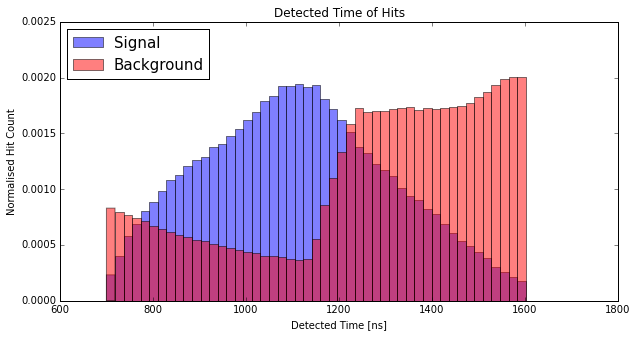

In [33]:
plot_feature( train_cdc.get_signal_hits()[train_cdc.time_name], 
              train_cdc.get_background_hits()[train_cdc.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

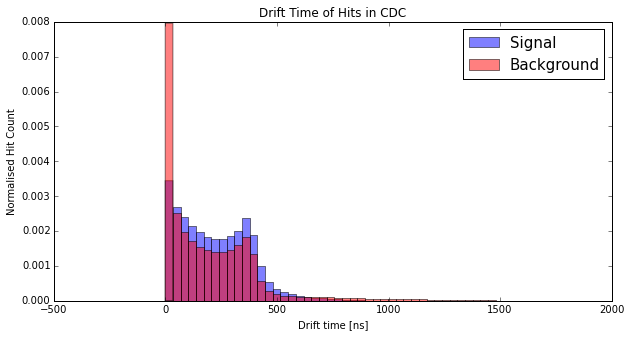

In [34]:
plot_feature( train_cdc.get_signal_hits()[drift_name], 
              train_cdc.get_background_hits()[drift_name], 
              xlabel="Drift time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Drift Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

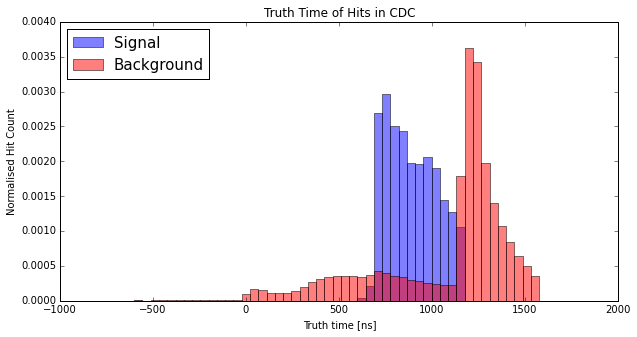

In [35]:
plot_feature( train_cdc.get_signal_hits()[train_cdc.time_name] -\
              train_cdc.get_signal_hits()[drift_name],  
              train_cdc.get_background_hits()[train_cdc.time_name] -\
              train_cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC",  
              nbins=bins_for_plots)
show()

# Begin the Analysis

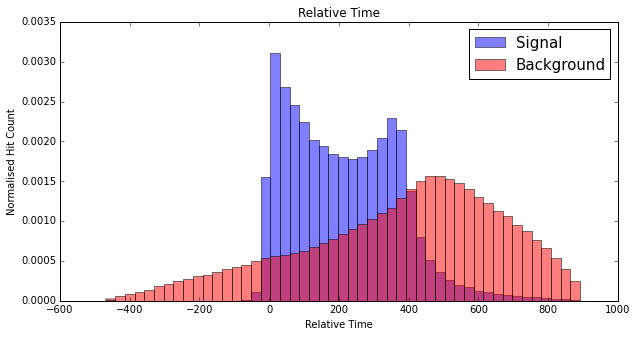

In [36]:
plot_feature( train_cdc.get_signal_hits()[rel_time_name], 
              train_cdc.get_background_hits()[rel_time_name], 
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

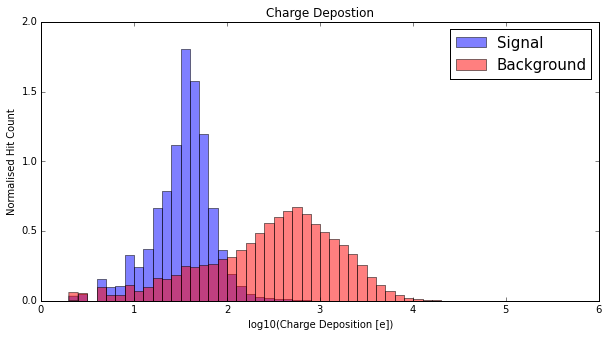

In [37]:
plot_feature( np.log10(train_cdc.get_signal_hits()[train_cdc.edep_name] + 1), 
              np.log10(train_cdc.get_background_hits()[train_cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

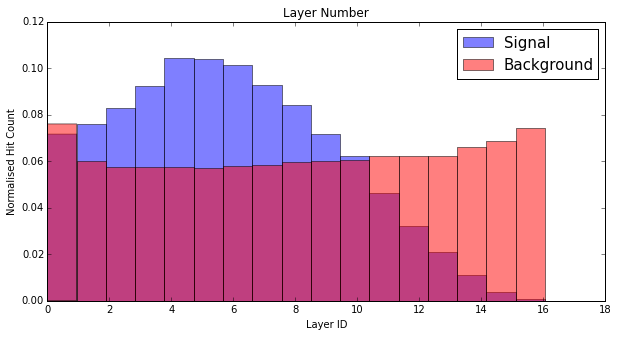

In [38]:
plot_feature( train_cdc.get_signal_hits()[train_cdc.row_name], 
              train_cdc.get_background_hits()[train_cdc.row_name], 
              xlabel="Layer ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Layer Number", 
              nbins=18)
show()

In [39]:
sig_occupancy, back_occupancy, occupancy = get_occupancy(train_cdc)

Sig Occ: 75.4093637455 , Back Occ : 502.55982393
All Occ: 569.199679872, 0.126996804969
NumHits: 665.286114446
MinChansMultiHit: 0.168809712956


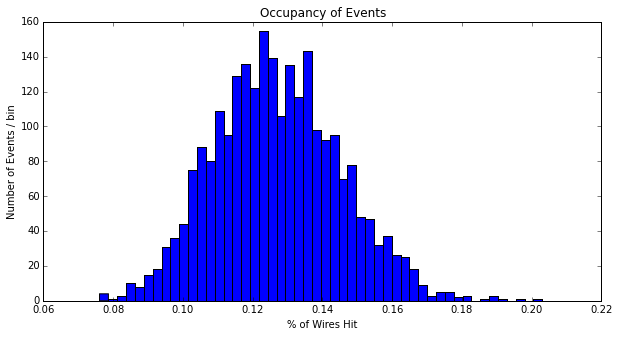

In [40]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occupancy)/4482., bins=50)
plt.show()

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [41]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [42]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train_cdc.n_events)
rest, sample_3     = train_test_split(rest, train_size=0.54, test_size=0.36, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.33, test_size=0.66, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_cdc)

### Classify Using Local Features

In [43]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [44]:
# Define Data
lcl_train_features = [train_cdc.edep_name, rel_time_name, train_cdc.row_name]

In [45]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
local_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=lcl_train_features)
# Add the GBDT
factory.add_classifier('Local Features', local_gbdt)

In [46]:
# Train the classifier
factory.fit(DataFrame(train_cdc.data[lcl_train_features][hit_masks[0]]), 
            train_cdc.data[train_cdc.hit_type_name][hit_masks[0]])
pass

model Local Features was trained in 34.15 seconds
Totally spent 34.15 seconds on training


In [47]:
train_cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fCellID
CDCHit.fHough_Score
CDCHit.fIsSig
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [48]:
# Print these predictions
train_cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(train_cdc.data[lcl_train_features]))[:,1]
# Invalidate the training sample
train_cdc.data[lcl_scr_name][hit_masks[0]] = -1
# remove the coincidence
remove_coincidence(train_cdc)
# Reset the sample masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_cdc)

Hits before coincidence removal : 1662550
{'is_sig, more_sig': 37946,
 'is_sig, no_more_sig': 15645,
 'not_sig, more_sig': 2051,
 'not_sig, no_sig': 131337}
246076
186979
Hits after coincidence removal : 1422430


0.982267077809


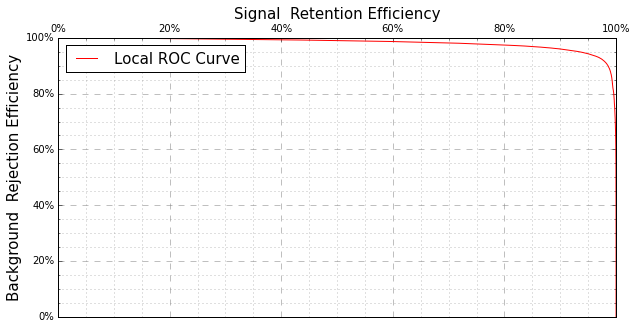

In [49]:
plot_roc_curve(train_cdc.data[train_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               train_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])], 
               zoom=False, label="Local ROC Curve")
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               train_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])])
plt.show()

## Use Neighbour Level Features

In [50]:
# Define Data
neigh_train_features = [train_cdc.edep_name, 
                        train_cdc.edep_name + "_left",
                        train_cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        train_cdc.row_name]

In [51]:
# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=neigh_train_features)
# Add the GBDT
factory.add_classifier('Neighbour and Local Features', neigh_gbdt)

In [52]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train_cdc, train_cdc.edep_name, evt_samp[1]) +\
                    get_measurment_and_neighbours(train_cdc, train_cdc.time_name, evt_samp[1]) +\
                    [train_cdc.data[train_cdc.row_name][hit_masks[1]]]).T,
                columns=neigh_train_features), 
            train_cdc.data[train_cdc.hit_type_name][hit_masks[1]])
pass

model Local Features was trained in 67.21 seconds
model Neighbour and Local Features was trained in 118.38 seconds
Totally spent 185.60 seconds on training


In [53]:
# Print these predictions
train_cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train_cdc, train_cdc.edep_name) +\
            get_measurment_and_neighbours(train_cdc, train_cdc.time_name) +\
            [train_cdc.data[train_cdc.row_name]]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train_cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.991114766196


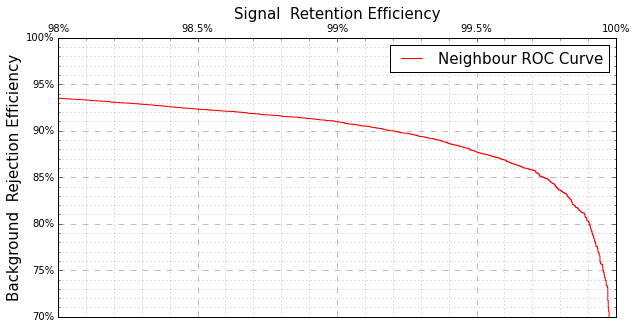

In [54]:
plot_roc_curve(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
               train_cdc.data[ngh_scr_name][hit_masks[2]], 
               zoom=True, label="Neighbour ROC Curve")
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
               train_cdc.data[ngh_scr_name][hit_masks[2]])
plt.show()

In [55]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]]
                        - train_cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [56]:
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
                    train_cdc.data[ngh_scr_name][hit_masks[2]])
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
                    train_cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2)

0.991114766196
0.2226133247


In [57]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [58]:
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     train_cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [59]:
# Get the hough results
#hough_score, hough_images = \
train_cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(train_cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

In [60]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=[train_cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)
local_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Track, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [61]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train_cdc, train_cdc.edep_name, evt_samp[2]) +\
                    get_measurment_and_neighbours(train_cdc, train_cdc.time_name, evt_samp[2]) +\
                    [train_cdc.data[train_cdc.row_name][hit_masks[2]]] +\
                    [train_cdc.data[hgh_scr_name][hit_masks[2]]]).T,
                columns=track_train_features), 
            train_cdc.data[train_cdc.hit_type_name][hit_masks[2]])
pass

model Local Features was trained in 142.31 seconds
model Neighbour and Local Features was trained in 234.58 seconds
model Track, Local and Neighbour Features was trained in 127.21 seconds
model Energy Deposition was trained in 71.65 seconds
Totally spent 575.76 seconds on training


## Save the Classifiers and Training Data

In [63]:
# Save the training sample and training data
import cPickle as pickle
from pandas import DataFrame

In [64]:
# Choose directory to save it to
classifiers_dir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/classifiers/"
#train_name = "batch_3_4_2500"
#test_name = "batch_5_2675"
train_name = "batch_3_2500"
test_name = "batch_4_2536"

save_class = False
load_class = False
save_test = False
load_test = False

In [65]:
if save_class:
    # Save the classifier
    pickle.dump(factory, open(classifiers_dir + "class_"+train_name+".p", "wb" ) )
    # Save the transformer 
    pickle.dump(hough_transformer, open(classifiers_dir + "hough_"+train_name+".p", "wb" ))
    # Save the training sample and remove it
    pickle.dump(train_cdc, open(classifiers_dir + "train_"+train_name+".p", "wb" ) )

In [66]:
print "Memory Usage {}".format(memory_usage())
%xdel train_cdc
print "Memory Usage {}".format(memory_usage())

Memory Usage [1149.73828125]
Memory Usage [826.90234375]


In [67]:
if load_class:
    factory = pickle.load(open(classifiers_dir + "class_"+train_name+".p", "rb" ) )
    hough_transformer = pickle.load(open(classifiers_dir + "hough_"+train_name+".p", "rb" ) )
    local_gbdt = factory['Local Features']
    neigh_gbdt = factory['Neighbour and Local Features']
    hough_gbdt = factory['Track, Local and Neighbour Features']

In [68]:
print "Memory Usage {}".format(memory_usage())

Memory Usage [826.90234375]


## Test on the New Sample

In [69]:
## For track fitting
these_branches = [drift_name, 
                  track_id_name]

these_branches += [turn_id_name, 
                   drift_dist_name,
                   pid_name,
                   parent_track_id_name] +\
                  hit_mom_names +\
                  all_momentum_names +\
                  all_pos_names +\
                  hit_pos_names

In [70]:
these_branches = [drift_name, 
                  track_id_name ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names
                
empty_branches = [prefix + row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [75]:
file_base = "/vols/build/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs/"
cdc_sig_file = file_base + "250k_combined_signal_batch_1.root"
cth_sig_file = cdc_sig_file

In [76]:
file_base = "/vols/build/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs/"
cdc_sig_file = file_base + "250k_combined_signal_batch_2.root"
cth_sig_file = cdc_sig_file

In [77]:
back_sample_root = "/vols/build/comet/users/elg112/ICEDUST"\
                   "/local_storage/Blessed_Outputs/"
cdc_back_file = back_sample_root + "3_2500_cdc_back.root"

In [78]:
back_sample_root = "/vols/build/comet/users/elg112/ICEDUST"\
                   "/local_storage/Blessed_Outputs/"
cdc_back_file = back_sample_root + "4_2536_cdc_back.root"
cdc_back_file_2 = None

In [79]:
import hits
reload(hits)
from hits import CDCHits

In [80]:
if load_test: 
    test_cdc = pickle.load(open(classifiers_dir + "test_"+test_name+".p", "rb" ) )
else:   
    test_cdc = import_hits_sample(cdc_sig_file, cth_sig_file, cdc_back_file,
                              empty_branches, these_branches,
                              lower_bound_time, upper_bound_time_cdc, 
                              upper_bound_time_cth, time_smear, back_file_2 = cdc_back_file_2)

Memory Usage [826.90625]
Imporing Signal Files : 
/vols/build/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_2.root
/vols/build/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_2.root
Number of CDC Events : 107336
Number of CDC Hits : 5728687
Number of CTH Events : 75988
Number of CTH Hits : 21091159
Number of events with both : 28624
Smearing Branch CDCHit.fDetectedTime
Smearing Branch CTHHit.fStartT
Before timing cut
CTH Hits: 14581336
CDC Hits: 2422053
After timing cut
CTH Hits: 11948157, 0.8194
CDC Hits: 2360591, 0.9746
Events left : 24734
Events that pass CTH Trigger: 23474
Passed Max Layer 20424
Passed Good Number of Hits : 21669
Removed due to CTH Trigger 1260
Removed due to Layer Cut 4310
Removed due to N Hits Cut 3065
After All Cuts 19090
Memory Usage [1794.6953125]

Imporing Background File : 
/vols/build/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/4_2536_cdc_back.root
Back Events : 2536
CyDe

In [81]:
if load_class:
    # Define features
    lcl_train_features = [test_cdc.edep_name, rel_time_name, test_cdc.row_name]
    neigh_train_features = [test_cdc.edep_name, 
                        test_cdc.edep_name + "_left",
                        test_cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        test_cdc.row_name]
    track_train_features = neigh_train_features + [hgh_scr_name]

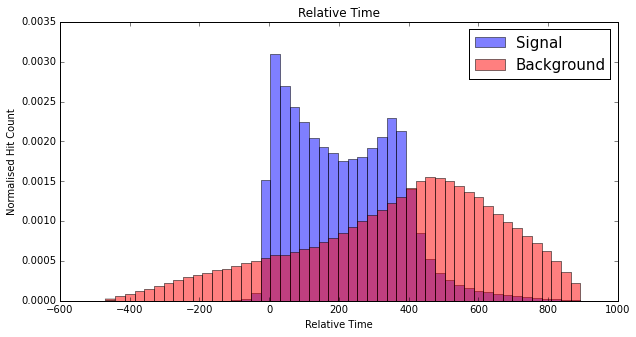

In [82]:
bins_for_plots = 50
plot_feature( test_cdc.get_signal_hits()[rel_time_name], 
              test_cdc.get_background_hits()[rel_time_name], 
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

In [83]:
if load_test:
    _ , hough_images = \
            hough_transformer.transform(test_cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                                    only_hits=True, flatten=True)
    default = [[31.5, 34, 34.5, 2]]
    submatrices = []

    # TODO test with several radii
    for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
        # Try with default values
        hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                           sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
else: 
    # Get the local score predictions
    test_cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(test_cdc.data[lcl_train_features]))[:,1]
    # Remove coincident hits
    remove_coincidence(test_cdc)
    # Get the neighbouring score predictions
    test_cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_cdc, test_cdc.edep_name) +\
                get_measurment_and_neighbours(test_cdc, test_cdc.time_name) +\
                [test_cdc.data[test_cdc.row_name]]).T,
            columns=neigh_train_features))[:,1]
    # Get the hough results
    test_cdc.data[hgh_scr_name], hough_images = \
            hough_transformer.transform(test_cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                       only_hits=True, flatten=True)
    # Test it on the last set of data
    test_cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
            DataFrame(
                np.vstack(
                        get_measurment_and_neighbours(test_cdc, test_cdc.edep_name) +\
                        get_measurment_and_neighbours(test_cdc, test_cdc.time_name) +\
                        [test_cdc.data[test_cdc.row_name]] +\
                        [test_cdc.data[hgh_scr_name]]).T,
                columns=track_train_features)
            )[:,1]

Hits before coincidence removal : 1678249
{'is_sig, more_sig': 36918,
 'is_sig, no_more_sig': 14073,
 'not_sig, more_sig': 4069,
 'not_sig, no_sig': 133152}
246250
188212
Hits after coincidence removal : 1439131


In [84]:
if save_test:
    # Save the test_sample
    pickle.dump(test_cdc, open(classifiers_dir + "test_"+test_name+".p", "wb" ) )

In [85]:
final_diagnostics = factory.test_on(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(test_cdc, test_cdc.edep_name) +\
            get_measurment_and_neighbours(test_cdc, test_cdc.time_name) +\
            [test_cdc.data[test_cdc.row_name]] +\
            [test_cdc.data[hgh_scr_name]]).T,
        columns=track_train_features), 
    test_cdc.data[test_cdc.hit_type_name])

# Visualize The Results

In [86]:
figsize(11, 7.3333)

/vols/build/comet/users/elg112/anaconda2/envs/default/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


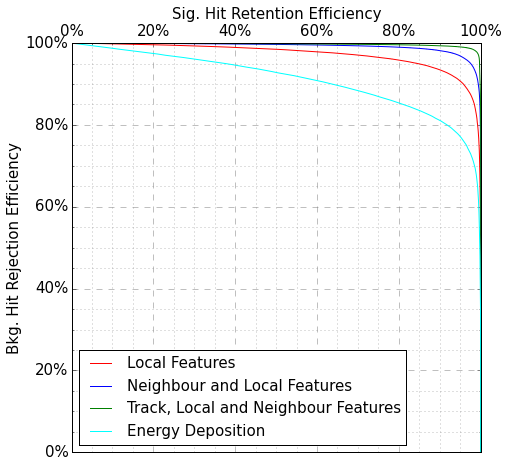

In [87]:
plot_set_font()
figsize(7.3333, 7.3333)
plot_rocs(test_cdc.get_measurement(test_cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         zoom=False,
         datum_label="Hit")
plt.show()

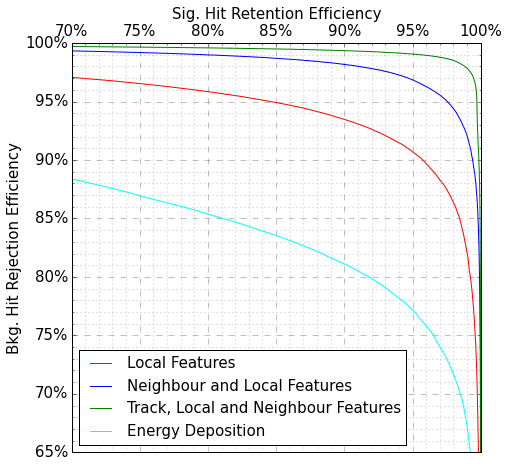

In [88]:
plot_set_font()
figsize(7.3333, 7.3333)
plot_rocs(test_cdc.get_measurement(test_cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         zoom=True,
         zoom_y_lims=[65,100],
         datum_label="Hit")
plt.show()

In [89]:
figsize(7.3333, 7.3333)

Sig Occ: 73.8619873817 , Back Occ : 493.618690852
All Occ: 567.480678233, 0.126613270467
NumHits: 567.480678233
MinChansMultiHit: 0.0


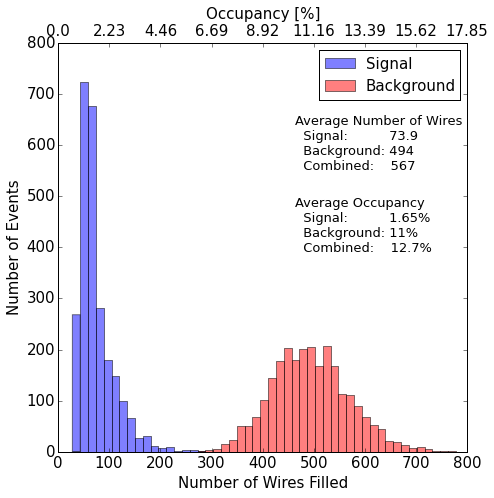

In [90]:
sig_occupy, back_occupy, occupy = get_occupancy(test_cdc)
plot_occupancies(sig_occupy, back_occupy, occupy)

In [91]:
sig_occ, back_occ, occ = list(), list(), list()
for event in range(test_cdc.n_events):
    sig_hits = test_cdc.filter_hits(test_cdc.get_signal_hits(event), "CDCHit.fTrack_Score",
                                    greater_than=0.106482)
                                    #greater_than=0.686765)
                                    #greater_than=0.441185)
                                    #greater_than=0.0354521)
                                    #greater_than=0.0997766)
                                    #greater_than=0.0362242)
    sig_occ += [len(np.unique(sig_hits[test_cdc.flat_name]))]
    bkg_hits = test_cdc.filter_hits(test_cdc.get_background_hits(event), "CDCHit.fTrack_Score",
                                    greater_than=0.106482)
                                    #greater_than=0.686765)
                                    #greater_than=0.441185)
                                    #greater_than=0.0354521)
                                    #greater_than=0.0997766)
                                    #greater_than=0.0362242)
    back_occ += [len(np.unique(bkg_hits[test_cdc.flat_name]))]
    all_evt_hits = test_cdc.filter_hits(test_cdc.get_events(event), "CDCHit.fTrack_Score",
                                    greater_than=0.106482)
                                    #greater_than=0.686765)
                                    #greater_than=0.441185)
                                    #greater_than=0.0354521)
                                    #greater_than=0.0997766)
                                    #greater_than=0.0362242)
    occ += [len(np.unique(all_evt_hits[test_cdc.flat_name]))]  

# print some infor
avg_n_hits = np.average(test_cdc.event_to_n_hits)
avg_occ = np.average(occ)
print "Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ))
print "All Occ: {}, {}".format(avg_occ, avg_occ/4482.)
print "NumHits: {}".format(avg_n_hits)
print "MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ))

Sig Occ: 73.2334384858 , Back Occ : 11.5378548896
All Occ: 84.7712933754, 0.0189137200748
NumHits: 567.480678233
MinChansMultiHit: 5.69425527956


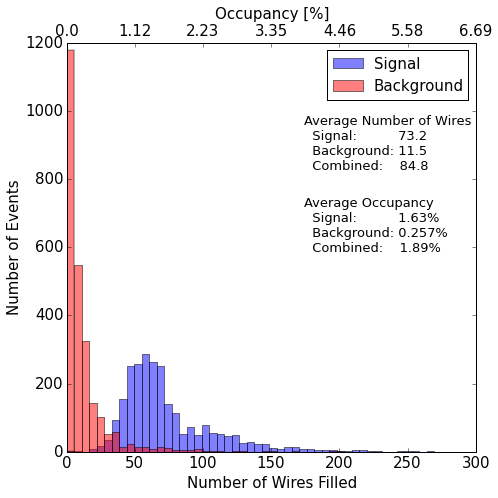

In [92]:
plot_set_font()
plot_occupancies(sig_occ, back_occ, occ)

In [93]:
figsize(5.5, 7.3333/2.)

In [94]:
labels = test_cdc.get_measurement(test_cdc.hit_type_name, 
                                  flatten=True)

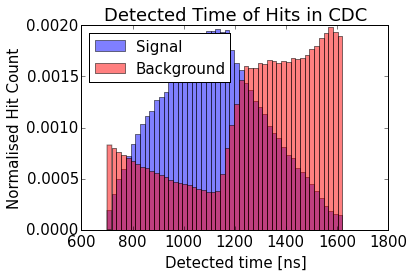

In [95]:
plot_feature( test_cdc.get_signal_hits()[test_cdc.time_name],
              test_cdc.get_background_hits()[test_cdc.time_name],
              xlabel="Detected time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

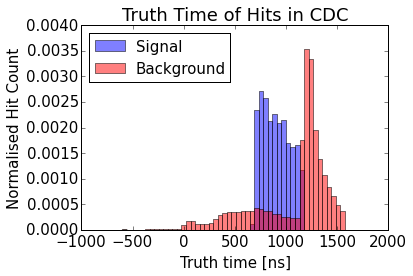

In [96]:
plot_feature( test_cdc.get_signal_hits()[test_cdc.time_name] -\
              test_cdc.get_signal_hits()[drift_name],  
              test_cdc.get_background_hits()[test_cdc.time_name] -\
              test_cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

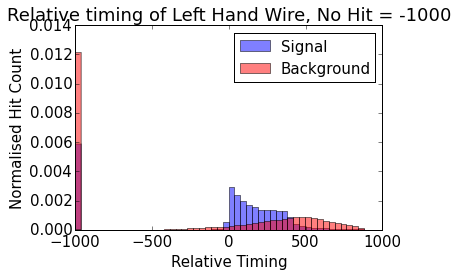

In [97]:
plot_feature(  test_cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 1], 
               test_cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 0], 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", 
              title="Relative timing of Left Hand Wire, No Hit = -1000",
              xlog=False, nbins=bins_for_plots)
show()

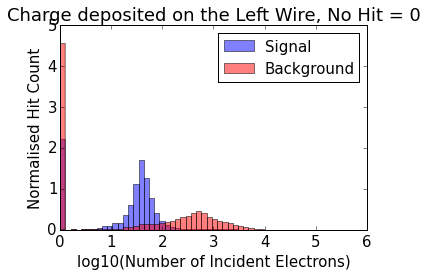

In [98]:
plot_feature(  np.log10(test_cdc.get_measurement(test_cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 1]), 
               np.log10(test_cdc.get_measurement(test_cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 0]), 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = 0", 
              nbins=bins_for_plots)
show()

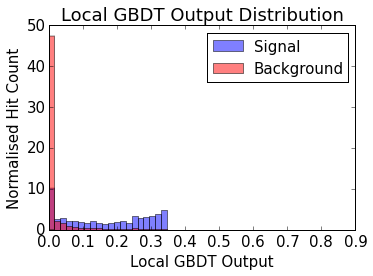

In [99]:
plot_feature( test_cdc.get_signal_hits()[lcl_scr_name], 
              test_cdc.get_background_hits()[lcl_scr_name],  
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=bins_for_plots)
show()

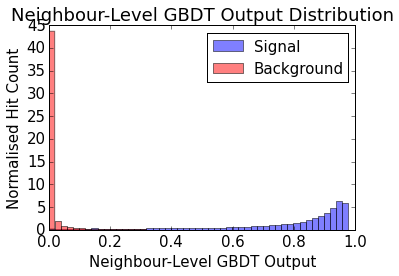

In [100]:
plot_feature( test_cdc.get_signal_hits()[ngh_scr_name], 
              test_cdc.get_background_hits()[ngh_scr_name], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=bins_for_plots)
show()

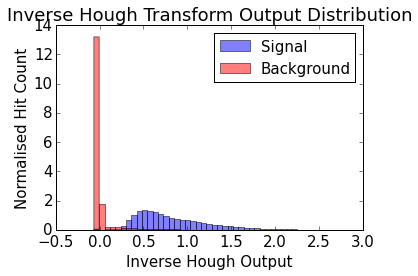

In [101]:
plot_feature( test_cdc.get_signal_hits()[hgh_scr_name], 
              test_cdc.get_background_hits()[hgh_scr_name], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Inverse Hough Transform Output Distribution", 
              nbins=bins_for_plots)
show()

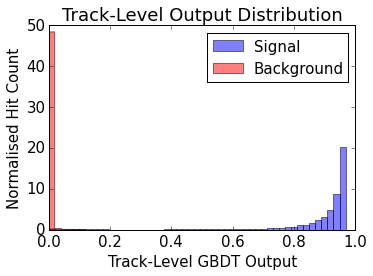

In [102]:
plot_feature( test_cdc.get_signal_hits()[trk_scr_name], 
              test_cdc.get_background_hits()[trk_scr_name],  
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Track-Level Output Distribution", 
              nbins=bins_for_plots)
show()

In [103]:
# TODO clean this up
from collections import OrderedDict

#figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (test_cdc.edep_name,          "Charge"),  
            (test_cdc.edep_name+"_left",  "Left Charge"),  
            (test_cdc.edep_name+"_right", "Right Charge"),  
            (test_cdc.row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j''$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict, font_size=None):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=True)
    ax = plt.subplot(111)
    ax.barh( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_yticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_xlabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='x' ,color='grey', linestyle='--', lw=2)
    ax.grid(b=True, which='minor', axis='x' , color='grey', linestyle=':', lw=2)
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_yticklabels(ordered_labels.values(), fontsize = font_size)
    #ax.set_xticks([tick for tick in ax.get_xticks()[::2]])
    ax.set_xticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_xticks()], fontsize = font_size)
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict, title="", font_size=None):
    corr = rep_factory.features_correlation_matrix(features=feat_label_dict.keys(),
                                tick_labels=feat_label_dict.values())
    corr.fontsize = font_size
    corr.cmap = "RdBu"
    return corr.plot(title=title)

/vols/build/comet/users/elg112/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


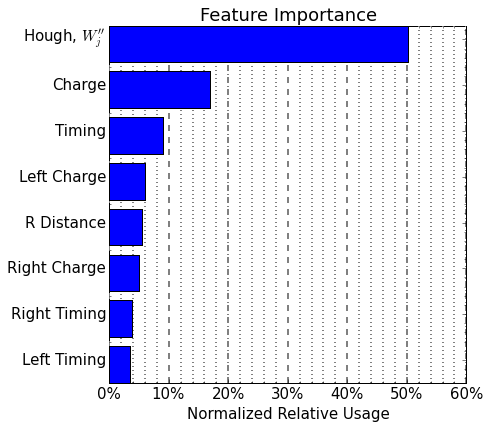

/vols/build/comet/users/elg112/anaconda2/envs/default/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/vols/build/comet/users/elg112/anaconda2/envs/default/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


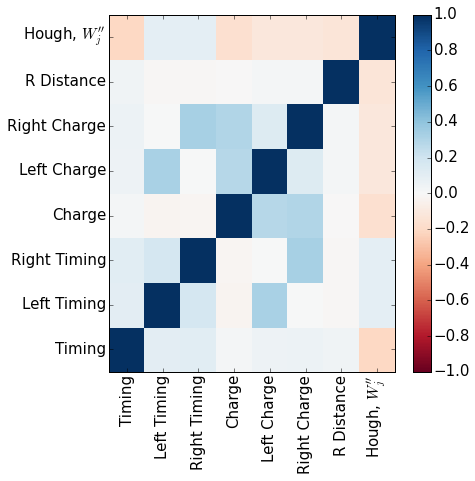

In [104]:
figsize(6.4,6.4) 
plot_feature_importance(hough_gbdt, feat_label_dict)
show()
plot_feature_correlations(final_diagnostics, feat_label_dict)
show()

/vols/build/comet/users/elg112/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


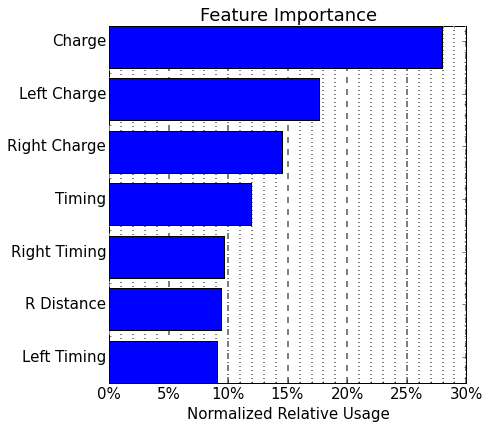

In [105]:
plot_feature_importance(neigh_gbdt, feat_label_dict)
show()

## Visualiaze the Data

In [106]:
high_hit = np.arange(test_cdc.n_events)[test_cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(test_cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print len(good_event)
print good_event

86
[   4   79  108  209  243  257  271  333  334  342  393  451  461  476  491
  495  496  516  571  572  632  638  649  660  711  724  751  759  865  884
  891  906  944  958 1009 1017 1026 1066 1190 1199 1205 1219 1236 1303 1310
 1313 1325 1399 1485 1504 1544 1555 1619 1630 1661 1684 1698 1705 1752 1808
 1853 1869 1871 1876 1891 1951 2021 2024 2087 2099 2143 2185 2194 2235 2265
 2322 2343 2368 2372 2391 2396 2476 2499 2507 2508 2516]


In [107]:
# Event information\
event = 19
event = good_event[event]
#event = evt_samp[3][event]
add_trans = True
save = False
savedir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/review_meeting_plots/"

to_plot = np.take([0,2,1], test_cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(test_cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(test_cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = test_cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)

#hough_event = evt_samp[3][event]
hough_event = event

plot_hough_image_3 = hough_images[hough_event,:hough.track.n_points] +\
                     hough_images[hough_event,hough.track.n_points:] 
plot_hough_no_rw = hough_transformer.normed_corresp.T.dot(ngh_pred_size.T).T
plot_hough_no_rw = plot_hough_no_rw[:hough.track.n_points] + plot_hough_no_rw[hough.track.n_points:]

732


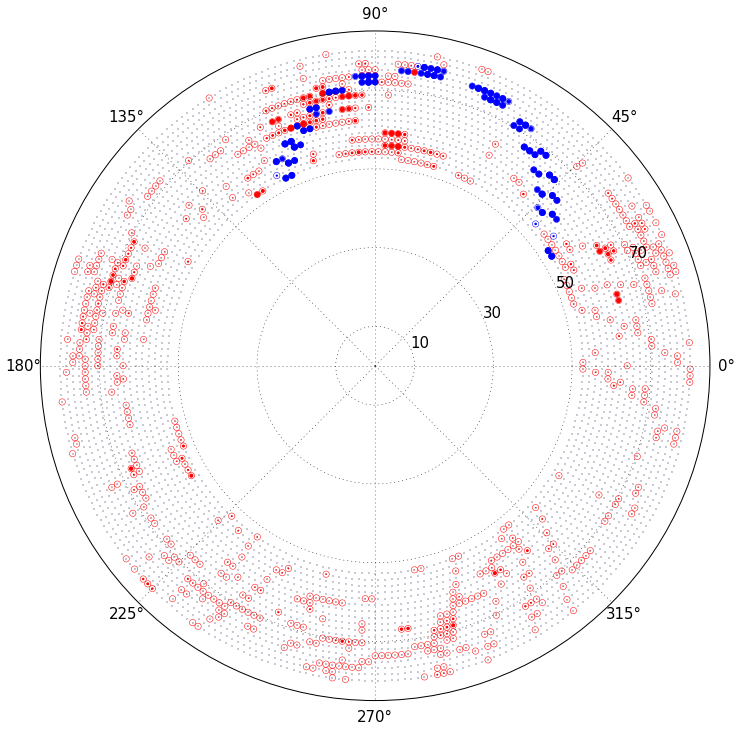

In [108]:
# First GBDT output
print occupy[event]
plot_output(to_plot, test_cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

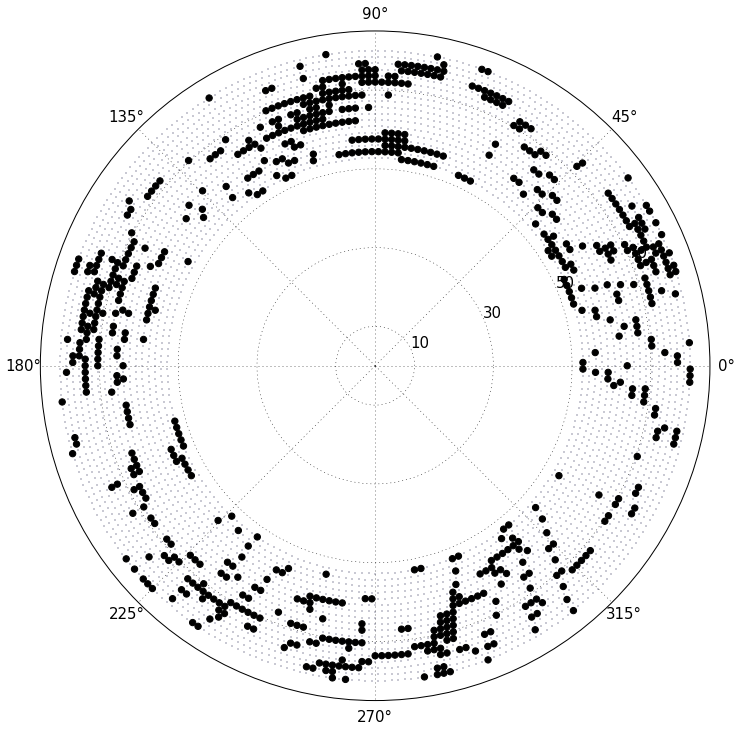

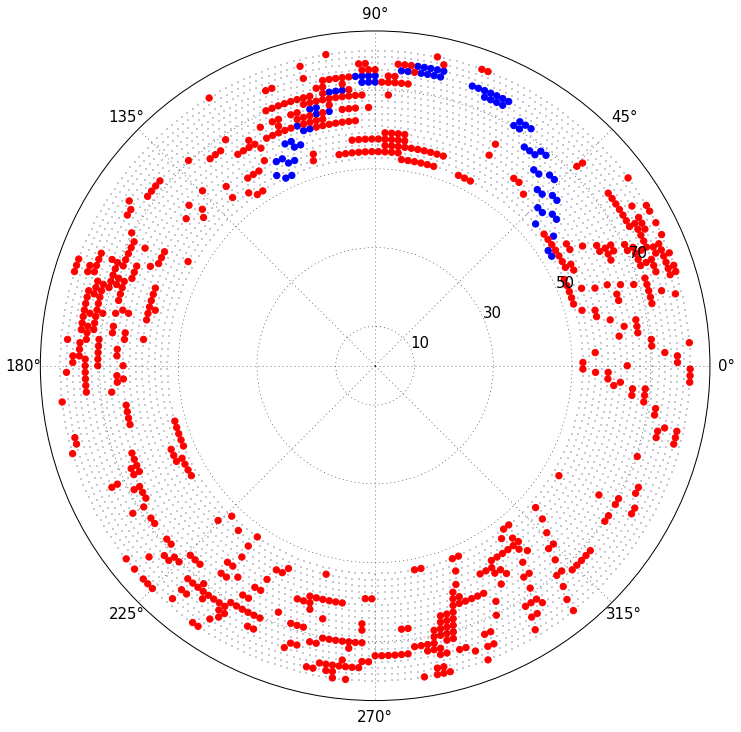

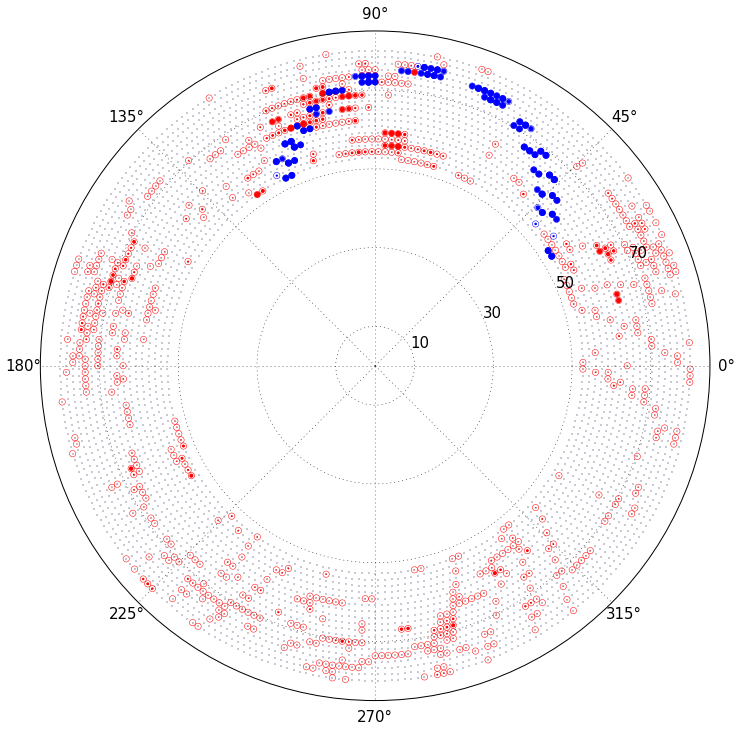

/vols/build/comet/users/elg112/anaconda2/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Length of draw tracks are 2147


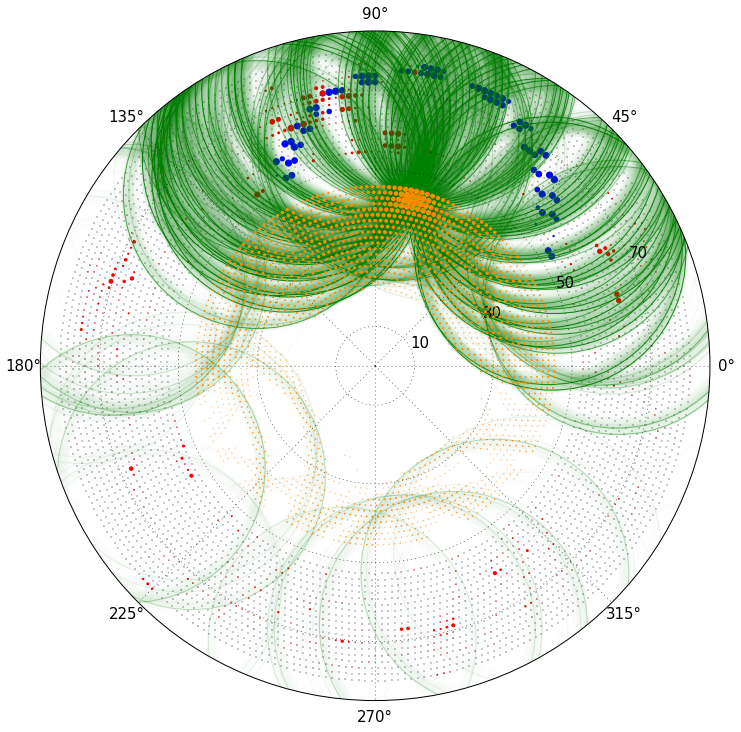

Length of draw tracks are 85


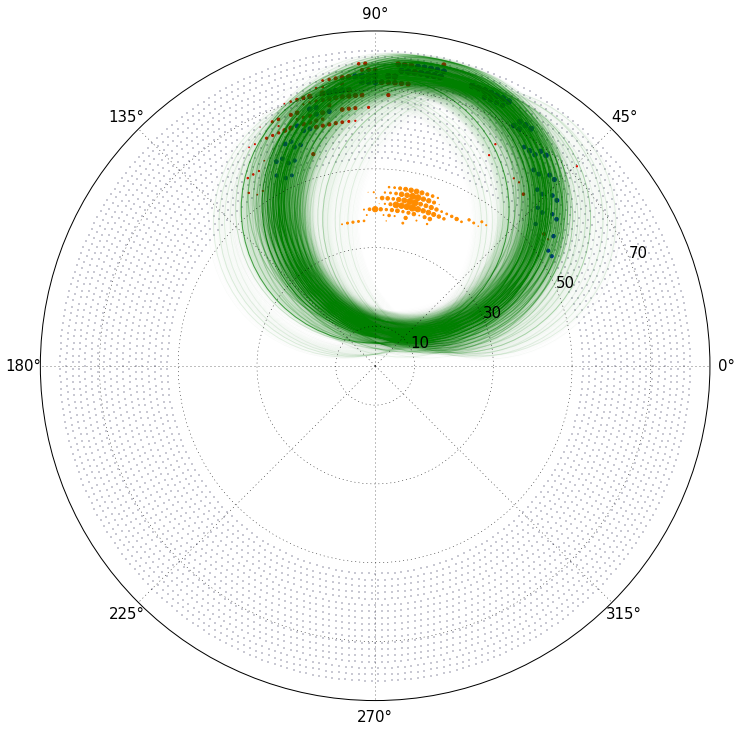

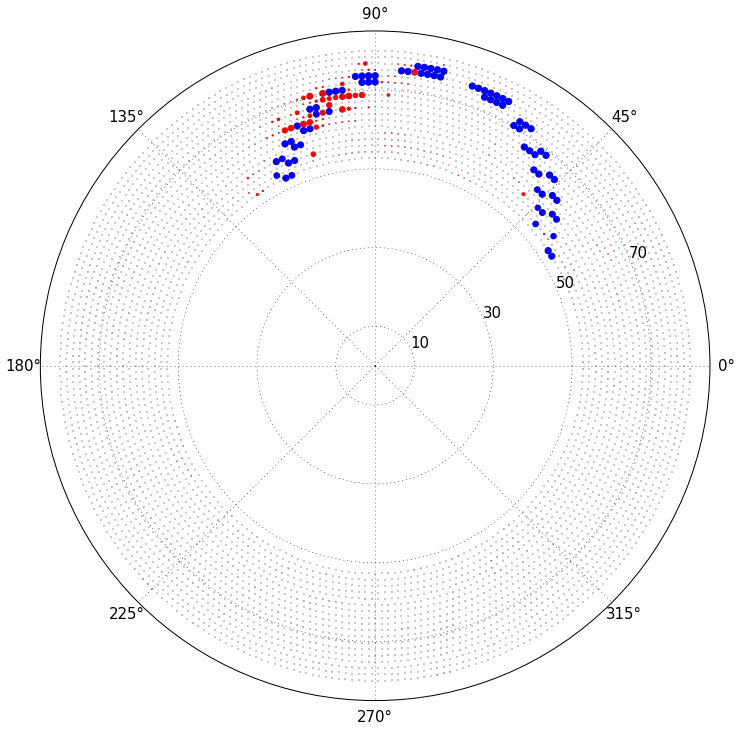

In [109]:
# Basic output
plot_output(to_plot, test_cdc.geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, test_cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, test_cdc.geom, 
            size=ngh_pred_size, 
            add_transform=add_trans)
plot_add_tracks(test_cdc.geom, hough, 
                size=plot_norm_size(plot_hough_no_rw - np.amin(plot_hough_no_rw),40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, test_cdc.geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(test_cdc.geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Final
plot_output(to_plot, test_cdc.geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [112]:
from tabulate import tabulate

ImportError: No module named tabulate

In [ ]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")

In [ ]:
fpr, tpr, thresh = roc_curve(test_cdc.data["CDCHit.fIsSig"], 
          test_cdc.data[trk_scr_name])

print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=1)

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=9000, threshold_max=10000, bins=10000, steps=1)

In [ ]:
# Final
plot_output(to_plot, test_cdc.geom, size=plot_norm_size(test_cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True) > 0.49132))
plot_add_outlines(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

## Export the Data

In [ ]:
export_name = "track_finding_sample_scored_2.root"

In [ ]:
test_cdc.trim_hits(test_cdc.hits_index_name, 
                   values=test_cdc.data[hit_masks[3]][test_cdc.hits_index_name])

In [1]:
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from rootpy.vector import LorentzVector
from rootpy import stl
from random import gauss, randint

# Map from python types to c++ types
type_dict_no_array = {dtype('float64'):"float", 
                      dtype('int32')  :"long",
                      dtype('int64')  :"long"}

type_dict_no_array = {dtype('float64'):"FloatCol()", 
                      dtype('int32')  :"IntCol()",
                      dtype('int64')  :"long"}

# Define the model of the output root file
class CDCTree(TreeModel):
    # Create a std::vector branch for each measurement
    for measure in test_cdc.data.dtype.names:
        this_dtype = type_dict[test_cdc.data.dtype[measure]]
        measure = measure.replace(".", "_")
        exec(measure + " = stl.vector(this_dtype)")
    # Delete branches we do not want
    del measure, this_dtype

# Open the output file
with root_open(savedir+export_name, mode='recreate') as output_file:
    # Open a new tree
    output_tree = Tree("test", model=CDCTree)
    for event in range(test_cdc.n_events):
        if event%100 == 0:
            print event
        event_hits = test_cdc.get_events(event)
        for measure in event_hits.dtype.names:
            this_measure = event_hits[measure]
            for hit_val in this_measure:
                output_tree[measure.replace(".","_")].push_back(hit_val)
        output_tree.fill(reset=True)
    output_tree.write()

INFO:rootpy.tree.chain] 2 files remaining
INFO:rootpy.tree.chain] current file: test_0.root
ERROR:ROOT.TFile.TFile] file test_0.root does not exist


ROOTError: level=3000, loc='TFile::TFile', msg='file test_0.root does not exist'

In [ ]:
fpr, tpr, thresh = roc_curve(test_cdc.data["CDCHit.fIsSig"], 
          test_cdc.data[trk_scr_name])

In [ ]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=5)

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Integrate trigger signal in


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.